# Intro

Task: Train classification models to determine the edibility of a dataset of mushrooms. The training set (primary_data) contains information about 173 species of mushrooms, such as cap diameter, color, habitat, etc, as well as a target class column denoting if it's edible. The test set (secondary_data), contains information on 61069 mushrooms based on these species. With this project, I will test several classification models, including Logistic Regression, Decision Trees, Random Forest, and K-Nearest Neighbors, which we have covered in class. I'd also like to incorporate Ridge Classifier, which is part of the scikit-learn library.

Given the presence of categorical and numeric columns in the dataset, I'd use OHE and StandardScaler to preprocess the data, then train these models using the primary dataset with a pipeline. Then, I'd compare the precision of these models against the secondary set, and choose the one with the highest score.

## Summary Findings
Random Forest produced the best results with a precision score of .9967, meaning only .33% of positive predictions were false. It's important to have a high precision score because false positives could lead you to eat a mushroom when it's poisonous, which is costly (both in terms of health and hospital bills).

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.metrics import ConfusionMatrixDisplay, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

# Data Source + Description:

The dataset came from Kaggle: https://www.kaggle.com/datasets/uciml/mushroom-classification, thought it was originally taken from the UCI Machine Learning Repository.

In [4]:
mushrooms = pd.read_csv('https://raw.githubusercontent.com/jess-iezhao/finalproject/refs/heads/main/mushrooms.csv', sep = ';')

In [5]:
mushrooms.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,...,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,...,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,...,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,...,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,...,s,y,w,u,w,t,p,NaN,d,w


This is a dataset of 61069 mushrooms with both numerical features (cap-diameter, stem-height, stem-width) and categorical (gill-color, has-ring, etc.) features. The target, 'class', is labeled either p for poisonous or e for edible. The goal of this project is to choose a classification model that will best predict whether a mushroom will be edible or not. I will be testing 5 models: logistic regression, decision tree, random forest, k-nearest neighbor, and ridge classifier.

In [6]:
mushrooms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 61069 non-null  object 
 1   cap-diameter          61069 non-null  float64
 2   cap-shape             61069 non-null  object 
 3   cap-surface           46949 non-null  object 
 4   cap-color             61069 non-null  object 
 5   does-bruise-or-bleed  61069 non-null  object 
 6   gill-attachment       51185 non-null  object 
 7   gill-spacing          36006 non-null  object 
 8   gill-color            61069 non-null  object 
 9   stem-height           61069 non-null  float64
 10  stem-width            61069 non-null  float64
 11  stem-root             9531 non-null   object 
 12  stem-surface          22945 non-null  object 
 13  stem-color            61069 non-null  object 
 14  veil-type             3177 non-null   object 
 15  veil-color         

In [7]:
mushrooms.dropna(axis = 1, inplace = True) #drop all columns with null values

#Models + Implementation

I will be cleaning the data by dropping null values, encoding 'p' or 'e' as 0 and 1, then applying standard scaler and OHE to numerical and categorical columns. Using this preprocessed data, I will run 80% of the dataset through the models (Logistic Regression, Ridge Classifier, Decision Trees, Random Forest, KNN) then test on the remainin 20% and find the precision scores.

To ensure that future processing runs smoothly, I will drop all of the columns with null values. Furthermore, columns with too many null values are likely not strong indicators of whether or not a mushroom will be edible, anyways.

In [8]:
mushrooms.head()
mushrooms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 61069 non-null  object 
 1   cap-diameter          61069 non-null  float64
 2   cap-shape             61069 non-null  object 
 3   cap-color             61069 non-null  object 
 4   does-bruise-or-bleed  61069 non-null  object 
 5   gill-color            61069 non-null  object 
 6   stem-height           61069 non-null  float64
 7   stem-width            61069 non-null  float64
 8   stem-color            61069 non-null  object 
 9   has-ring              61069 non-null  object 
 10  habitat               61069 non-null  object 
 11  season                61069 non-null  object 
dtypes: float64(3), object(9)
memory usage: 5.6+ MB


After removing null value columns, we are left with 10 features to model: cap-diameter, cap-shape, cap-color, does-bruise-or-bleed, gill-color, stem-height, stem-width, stem-color, has-ring, habitat, and season.

In [18]:
numeric_features = ['cap-diameter', 'stem-height', 'stem-width']
categorical_features = ['cap-shape', 'cap-color', 'does-bruise-or-bleed', 'gill-color', 'stem-color', 'has-ring', 'habitat', 'season']

In [25]:
le = LabelEncoder()
mushrooms['class'] = 1 - le.fit_transform(mushrooms['class'])

mushrooms.head()

#turn poisonous into 0 and edible into 1

,class,cap-diameter,cap-shape,cap-color,does-bruise-or-bleed,gill-color,stem-height,stem-width,stem-color,has-ring,habitat,season
0,0,15.26,x,o,f,w,16.95,17.09,w,t,d,w
1,0,16.60,x,o,f,w,17.99,18.19,w,t,d,u
2,0,14.07,x,o,f,w,17.80,17.74,w,t,d,w
3,0,14.17,f,e,f,w,15.77,15.98,w,t,d,w
4,0,14.64,x,o,f,w,16.53,17.20,w,t,d,w


The target column came with 'p' or 'e' as a label, but some classifier models need a binary 0 or 1. I imported LabelEncoder to turn these 'p' and 'e' into 0 and 1, respectively.

# 1 = edible
# 0 = poisonous

In [23]:
for col in categorical_features:
    print(f"Value counts for column '{col}':")
    print(mushrooms[col].value_counts())
    print()

Value counts for column 'cap-shape':
cap-shape
x    26934
f    13404
s     7164
b     5694
o     3460
p     2598
c     1815
Name: count, dtype: int64

Value counts for column 'cap-color':
cap-color
n    24218
y     8543
w     7666
g     4420
e     4035
o     3656
r     1782
u     1709
p     1703
k     1279
b     1230
l      828
Name: count, dtype: int64

Value counts for column 'does-bruise-or-bleed':
does-bruise-or-bleed
f    50479
t    10590
Name: count, dtype: int64

Value counts for column 'gill-color':
gill-color
w    18521
n     9645
y     9546
p     5983
g     4118
f     3530
o     2909
k     2375
r     1399
e     1066
u     1023
b      954
Name: count, dtype: int64

Value counts for column 'stem-color':
stem-color
w    22926
n    18063
y     7865
g     2626
o     2187
e     2050
u     1490
f     1059
p     1025
k      837
r      542
l      226
b      173
Name: count, dtype: int64

Value counts for column 'has-ring':
has-ring
f    45890
t    15179
Name: count, dtype: int64

Valu

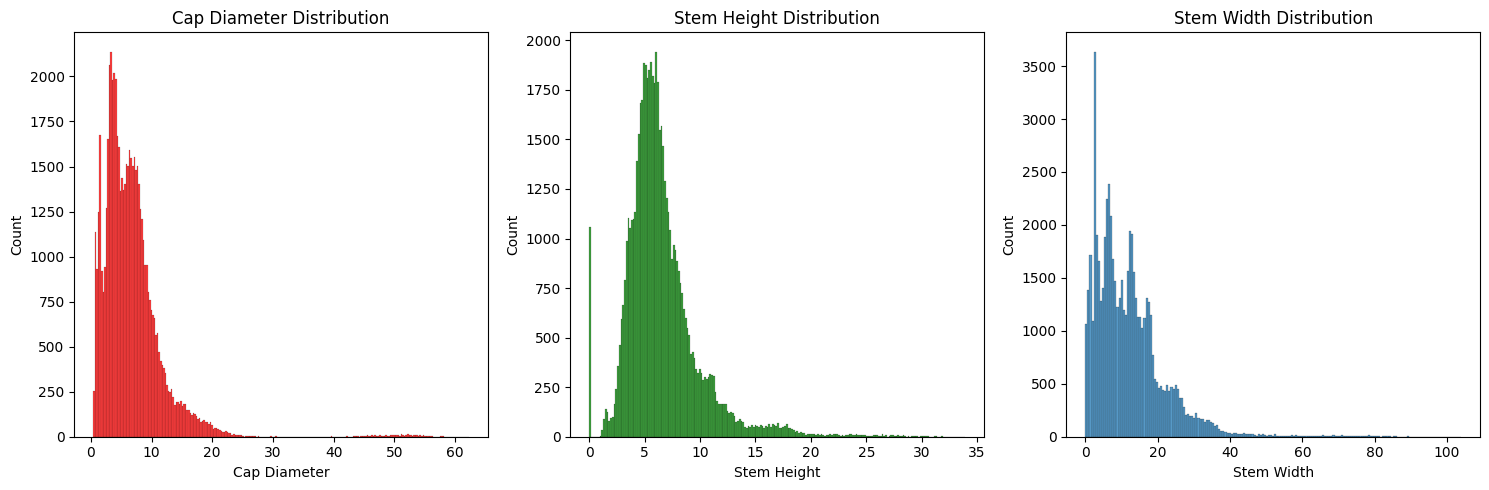

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(data = mushrooms, x = 'cap-diameter', ax = ax[0], color = 'red')
ax[0].set_title('Cap Diameter Distribution')
ax[0].set_xlabel('Cap Diameter')
ax[0].set_ylabel('Count')

sns.histplot(data = mushrooms, x = 'stem-height', ax = ax[1], color = 'green')
ax[1].set_title('Stem Height Distribution')
ax[1].set_xlabel('Stem Height')
ax[1].set_ylabel('Count')

sns.histplot(data = mushrooms, x = 'stem-width', ax = ax[2])
ax[2].set_title('Stem Width Distribution')
ax[2].set_xlabel('Stem Width')
ax[2].set_ylabel('Count')

plt.tight_layout()
plt.show()

#observing column distributions

Next, I wanted to take a closer look at the numeric features. All 3 show a slight right skew, with Stem Heights having a large cluster at 0 as well. Because they are not normally distributed or on the same scale, I'll want to apply StandardScaler later to ensure that they are contributing equally to the model.

In [26]:
X = mushrooms.drop('class', axis = 1)
y = mushrooms['class'] #set X and y

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

I used 80% of the data to train the models, then left the remaining 20% to test.

In [28]:


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

Because there were categorical features, I imported and applied OneHotEncoder to ensure compatibility with the classification models.

In [29]:
logistic_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression()),
])

forest_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier()),
])

tree_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier()),
])

KNN_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier()),
])

ridge_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RidgeClassifier()),
])

Using the preprocessor including StandardScaler and OHE, I created pipelines for each of the 5 models I wanted to test. Next, I'll find the precision scores of each model on the remaining 20% of the data, and select the ones with the highest scores.

In [30]:
ridge_pipe.fit(X_train, y_train)
y_pred_ridge = ridge_pipe.predict(X_test)
ridge_precision = precision_score(y_test, y_pred_ridge)
print(f'Ridge Classifier Precision: {ridge_precision}')

Ridge Classifier Precision: 0.7141478479058097


In [33]:
param_grid_ridge = {
    'classifier__alpha': [0.1, 1, 10, 100],
    'classifier__solver': ['auto', 'sag', 'lsqr']
}

grid_search = GridSearchCV(ridge_pipe, param_grid_ridge, cv=5, scoring = 'precision')
grid_search.fit(X_train, y_train)

best_ridge_pipe = grid_search.best_estimator_

y_pred_ridge_tuned = best_ridge_pipe.predict(X_test)
ridge_precision_tuned = precision_score(y_test, y_pred_ridge_tuned)
print(f'Ridge Classifier Precision after Parameter Tuning: {ridge_precision_tuned}')

Ridge Classifier Precision after Parameter Tuning: 0.713258164852255


After applying GridSearch, the precision score actually decreased. This could be a sign of overfitting, and the original model seems adequate. Let's compare this Ridge Classifier with the others.

In [37]:
logistic_pipe.fit(X_train, y_train)
y_pred_logistic = logistic_pipe.predict(X_test)
logistic_precision = precision_score(y_test, y_pred_logistic)
print(f'Logistic Regression Precision: {logistic_precision}')

Logistic Regression Precision: 0.7106472615855994


In [38]:
param_grid_logistic = {
    'classifier__C': [0.01, 0.1, 1, 10],  # Regularization strength
    'classifier__solver': ['liblinear', 'lbfgs'], # Solvers supported by Logistic Regression
    'classifier__max_iter': [100, 500]
}

grid_search = GridSearchCV(logistic_pipe, param_grid_logistic, cv=5, scoring = 'precision')
grid_search.fit(X_train, y_train)

best_logistic_pipe = grid_search.best_estimator_

y_pred_logistic_tuned = best_logistic_pipe.predict(X_test)
logistic_precision_tuned = precision_score(y_test, y_pred_logistic_tuned)
print(logistic_precision_tuned)


0.7188


Applying Grid Search to Logistic Regression slightly increased the precision score, but not but a significant amount either.

In [41]:
forest_pipe.fit(X_train, y_train)
y_pred_forest = forest_pipe.predict(X_test)
forest_precision = precision_score(y_test, y_pred_forest)
print(f'Random Forest Precision: {forest_precision}')

Random Forest Precision: 0.99674914213473


In [34]:
param_grid_forest = {
    'classifier__n_estimators': [1, 10, 20],  # Number of trees in the forest
    'classifier__max_depth': [None, 10, 20],    # Maximum depth of the trees
}

grid_search = GridSearchCV(forest_pipe, param_grid_forest, cv=5, scoring = 'precision')
grid_search.fit(X_train, y_train)

best_forest_pipe = grid_search.best_estimator_

y_pred_forest_tuned = best_forest_pipe.predict(X_test)
forest_precision_tuned = precision_score(y_test, y_pred_forest_tuned)
print(f'Random Forest Precision after Tuning: {forest_precision_tuned}')

Random Forest Precision after Tuning: 0.9967385395905055


In [42]:
tree_pipe.fit(X_train, y_train)
y_pred_tree = tree_pipe.predict(X_test)
tree_precision = precision_score(y_test, y_pred_tree)
print(f'Decision Tree Precision: {tree_precision}')

Decision Tree Precision: 0.9886117136659436


In [43]:
param_grid_tree = {
    'classifier__max_depth': [None, 10, 20],     # Maximum depth of the tree
    'classifier__criterion': ['gini', 'entropy']    # Split criterion
}

grid_search = GridSearchCV(tree_pipe, param_grid_tree, cv=5, scoring = 'precision')
grid_search.fit(X_train, y_train)

best_tree_pipe = grid_search.best_estimator_

y_pred_tree_tuned = best_tree_pipe.predict(X_test)
tree_precision_tuned = precision_score(y_test, y_pred_tree_tuned)
print(tree_precision_tuned)



0.9907742402315485


Similarly, grid searching random forest and decision trees didn't improve the precision score. A note--I did reduce the number of parameters to search because it was taking a while to load on my computer. Perhaps there were parameters I didn't search that could have optimized my models further, but I lacked the computing power to run the code.

In [44]:
KNN_pipe.fit(X_train, y_train)
y_pred_KNN = KNN_pipe.predict(X_test)
KNN_precision = precision_score(y_test, y_pred_KNN)
print(f'K-Nearest Neighbors Precision: {KNN_precision}')

K-Nearest Neighbors Precision: 0.9962039045553145


The KNN Model had a very high precision score, similar to Random Forest and Decision Tree, so I did not run the Grid Search here.

In [45]:
print(classification_report(y_test, y_pred_logistic))

              precision    recall  f1-score   support

           0       0.74      0.77      0.76      6674
           1       0.71      0.67      0.69      5540

    accuracy                           0.73     12214
   macro avg       0.72      0.72      0.72     12214
weighted avg       0.73      0.73      0.73     12214



Text(0.5, 1.0, 'Ridge Classifier')

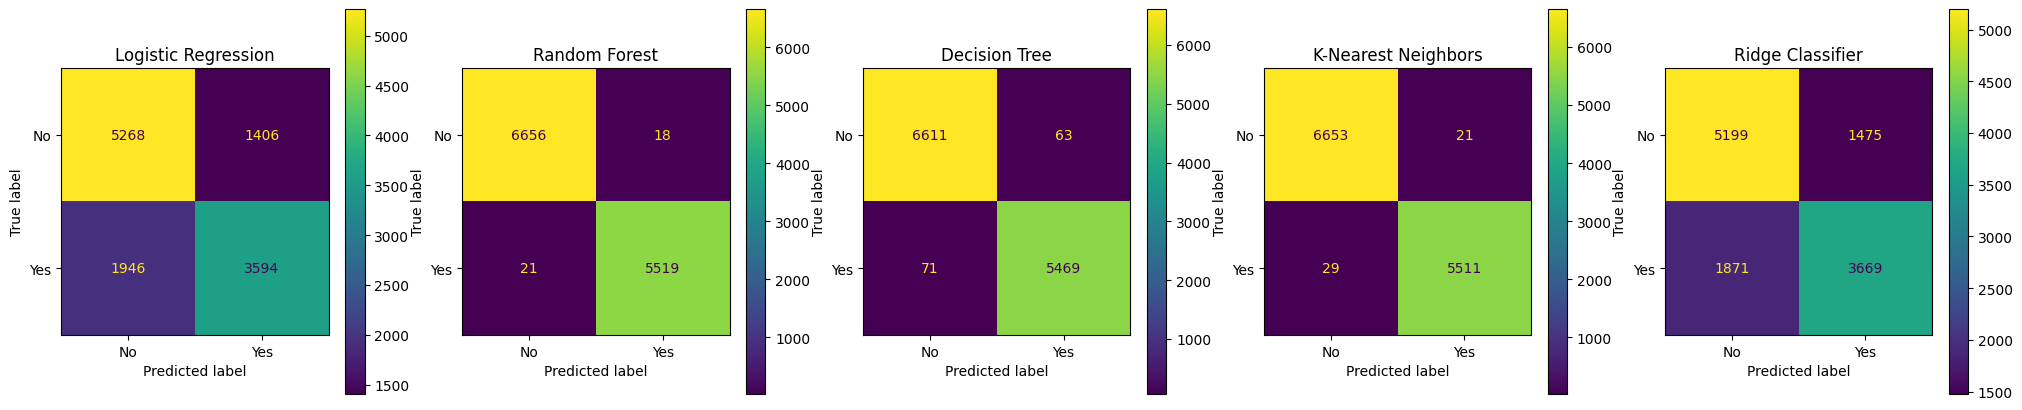

In [46]:
logistic_cmat = confusion_matrix(y_test, y_pred_logistic_tuned)
forest_cmat = confusion_matrix(y_test, y_pred_forest)
tree_cmat = confusion_matrix(y_test, y_pred_tree)
KNN_cmat = confusion_matrix(y_test, y_pred_KNN)
ridge_cmat = confusion_matrix(y_test, y_pred_ridge_tuned)

fig, ax = plt.subplots(1,5, figsize = (25,5))

ConfusionMatrixDisplay(logistic_cmat, display_labels = ['No', 'Yes']).plot(ax = ax[0])
ax[0].set_title('Logistic Regression')

ConfusionMatrixDisplay(forest_cmat, display_labels = ['No', 'Yes']).plot(ax = ax[1])
ax[1].set_title('Random Forest')

ConfusionMatrixDisplay(tree_cmat, display_labels = ['No', 'Yes']).plot(ax = ax[2])
ax[2].set_title('Decision Tree')

ConfusionMatrixDisplay(KNN_cmat, display_labels = ['No', 'Yes']).plot(ax = ax[3])
ax[3].set_title('K-Nearest Neighbors')

ConfusionMatrixDisplay(ridge_cmat, display_labels = ['No', 'Yes']).plot(ax = ax[4])
ax[4].set_title('Ridge Classifier')

#random forest seems best, followed by KNN then decision trees

#Results and Next Steps
From the confusion matrices, it seems like Random Forest was the most precise, followed by KNN and then Decision Trees. This ranking was established based on how many true positives and true negatives each model was able to identify on the remaining 20% of the dataset. Ridge Classifier and Logistic Regression have quite a few errors (Predicted Label differes from True Label).

As for Next Steps, I'd like to run Grid Searches with expanded parameters on Logistic Regression and Ridge Classifier, as they have relatively lower precision scores (~.70 vs. >.99). It would also be interesting to compare with different performance metrics; I chose precision because a false positive (mushroom labeled edible but is actually not) would be very costly, but it may be interesting to see if other metrics display different results.